<a href="https://colab.research.google.com/github/Koanah/Fake-News-Detection/blob/main/Fake_News_Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim

In [ ]:
import gensim

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

FAKE NEWS DATASET ANALYSIS

In [ ]:
fake_news = pd.read_csv("/content/fake.csv")

In [ ]:
fake_news.head()


In [ ]:
fake_news.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
fake_news['text'][0]

In [ ]:
# get the average number of words per text:
average_word_count = fake_news['text'].apply(lambda x: len(str(x).split())).mean()
print(f'Average number of words per text: {average_word_count:.2f}')

Average number of words per text: 423.20


In [ ]:
fake_news['subject'].value_counts()

In [ ]:
# pie chart to visualize the distrubution of the subjects in the dataset
subject_counts = fake_news['subject'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(subject_counts, labels=subject_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Subjects')
plt.axis('equal')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject', data = fake_news)

In [ ]:
# term frequency bar plot  - use a horizontal or vertical bar plot of the top N most frequent word
from collections import Counter

In [ ]:
words = ' '.join(fake_news['text']).split()
common_words = Counter(words).most_common(20)
words_df = pd.DataFrame(common_words, columns=['word', 'count'])

sns.barplot(data=words_df, y='word', x='count')

In [ ]:
# check for any empty rows in the fake news dataset:
def find_empty_rows(df, text_column='text'):
    # Find empty or whitespace-only or null rows
    empty_rows = df[df[text_column].str.strip().eq('') | df[text_column].isnull()]

    if not empty_rows.empty:
        print(f"Empty text rows found at indices: {list(empty_rows.index)}")
    else:
        print("No empty text rows found.")

    return empty_rows

In [ ]:
def remove_empty_rows(df, text_column='text'):
    # Find rows where the specified column is empty or contains only whitespace
    empty_rows = df[df[text_column].str.strip().eq('') | df[text_column].isnull()]

    if not empty_rows.empty:
        print(f"Dropping the following empty row indices: {list(empty_rows.index)}")
        df = df.drop(empty_rows.index, axis=0)
    else:
        print("No empty rows found.")

    return df

In [ ]:
find_empty_rows(fake_news, text_column='text')

In [ ]:
remove_empty_rows(fake_news,'text')

In [ ]:
fake_news['text'][10923]

' '

Analysis of the real news dataset:

In [ ]:
real_news = pd.read_csv('/content/true.csv')

In [ ]:
real_news.head()

In [ ]:
real_news['text'][0]

In [ ]:
# get the average number of words per text:
average_word_count = real_news['text'].apply(lambda x: len(str(x).split())).mean()
print(f'Average number of words per text: {average_word_count:.2f}')

Average number of words per text: 385.64


In [ ]:
text = ' '.join(real_news['text'].tolist())

In [ ]:
real_news['subject'].value_counts()

In [ ]:
#Pie chart to visualize the distribution of the news
subject_counts = real_news['subject'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(subject_counts, labels=subject_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Subjects in real news')
plt.axis('equal')  # Equal aspect ratio makes the pie a circle
plt.show()

In [ ]:
words = ' '.join(real_news['text']).split()
common_words = Counter(words).most_common(20)
words_df = pd.DataFrame(common_words, columns=['word', 'count'])

sns.barplot(data=words_df, y='word', x='count')

In [ ]:
real_news.sample(5)

In [ ]:
# create list of indexes which do not have publication information by breaking text with hyphen
import re

pattern = re.compile(r'^.{0,119} - .+')

unknown_publishers = [
    i for i, text in enumerate(real_news.text.values)
    if not pattern.match(text)
]

In [ ]:
len(unknown_publishers)

229

In [ ]:
real_news.iloc[unknown_publishers].text

In [ ]:
find_empty_rows(real_news,'text')

In [ ]:
real_news =remove_empty_rows(real_news)

Dropping the following empty row indices: [8970]


In [ ]:
publisher = []
tmp_text = [] # for unknown publishers

for index, row in enumerate(real_news.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')
    continue
  else:
    record = row.split('-', maxsplit = 1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [ ]:
real_news['publisher'] = publisher
real_news['text'] = tmp_text


In [ ]:
real_news.shape

(21416, 5)

In [ ]:
publisher

['WASHINGTON (Reuters)',
 'WASHINGTON (Reuters)',
 'WASHINGTON (Reuters)',
 'WASHINGTON (Reuters)',
 'SEATTLE/WASHINGTON (Reuters)',
 'WEST PALM BEACH, Fla./WASHINGTON (Reuters)',
 'WEST PALM BEACH, Fla (Reuters)',
 'Unknown',
 'Unknown',
 'WASHINGTON (Reuters)',
 '(Reuters)',
 'NEW YORK/WASHINGTON (Reuters)',
 'Unknown',
 'Unknown',
 'Unknown',
 '(Reuters)',
 'WASHINGTON (Reuters)',
 'Unknown',
 '(Reuters)',
 '(Reuters)',
 'WASHINGTON (Reuters)',
 'NEW YORK (Reuters)',
 '(Reuters)',
 'WASHINGTON (Reuters)',
 'LIMA (Reuters)',
 'WASHINGTON (Reuters)',
 'WASHINGTON (Reuters)',
 'Unknown',
 'MEXICO CITY (Reuters)',
 'WASHINGTON (Reuters)',
 '(Reuters)',
 'WASHINGTON (Reuters)',
 'WASHINGTON (Reuters)',
 'VATICAN CITY (Reuters)',
 'KING OF PRUSSIA, Pennsylvania/WASHINGTON (Reuters)',
 '(Reuters)',
 'WASHINGTON (Reuters)',
 '(Reuters)',
 'NEW YORK (Reuters)',
 'WASHINGTON (Reuters)',
 'Unknown',
 'WASHINGTON (Reuters)',
 'NEW YORK (Reuters)',
 'WASHINGTON (Reuters)',
 'WASHINGTON (Reuters)

In [ ]:
real_news['text'] = real_news['title'] + " " + real_news['text']
fake_news['text'] = fake_news['title'] + " " + fake_news['text']

In [ ]:
real_news['text']  = real_news['text'].apply(lambda x: str(x).lower())
fake_news['text'] = fake_news['text'].apply(lambda x: str(x).lower())

In [ ]:
real_news['class'] = 1
fake_news['class'] = 0

In [ ]:
real_news = real_news[['text','class']]

In [ ]:
fake_news = fake_news[['text', 'class']]

In [ ]:
data = pd.concat([real_news, fake_news], ignore_index=True)

In [ ]:
data.sample(20)

PREPROCESSING THE DATA

In [ ]:
import re
import unicodedata
import pandas as pd

In [ ]:
def clean_text(text):

    text = text.lower() # convert all text to lowercase
    text = text.replace('\\', '') # remove all backslashes
    text = text.replace('-', ' ') # remove any additional hyphens
    text = re.sub(r'\S+@\S+', '', text) #remove emails
    text = re.sub(r'@\w+', '', text)  #remove twitter handle
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) #remove urls
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')  # Remove accented characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters and punctuation (keep only letters and numbers)
    text = re.sub(r'\s+', ' ', text).strip()    # Remove extra spaces

    return text

In [ ]:
data['text'] = data['text'].apply(clean_text)

In [ ]:
data['text'].head()

using a vectorization technique such as Word2Vec to vectorize the data

In [ ]:
y = data['class'].values


In [ ]:
X=[d.split() for d in data['text'].tolist()]

In [ ]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [ ]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count=1)

In [ ]:
len(w2v_model.wv.key_to_index)

197506

In [ ]:
w2v_model.wv.most_similar('weather')

[('tropical', 0.7090049386024475),
 ('temperatures', 0.6580345630645752),
 ('storms', 0.6523522138595581),
 ('rains', 0.6515286564826965),
 ('irma', 0.6400080323219299),
 ('storm', 0.639491081237793),
 ('floods', 0.6376432180404663),
 ('flooding', 0.6265140771865845),
 ('landslides', 0.6157400608062744),
 ('winds', 0.611072838306427)]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
nos = np.fromiter((len(seq) for seq in X), dtype=int)
count = np.sum(nos > 1000)
print(count)

1641


In [ ]:
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
len(X[101])

1000

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
def create_embedding_matrix(w2v_model, tokenizer, embedding_dim, vocab_size):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in tokenizer.word_index.items():
        if word in w2v_model.wv:
            embedding_vector = w2v_model.wv[word]
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [ ]:
embedding_vectors = create_embedding_matrix(w2v_model, tokenizer, 100, vocab_size)

In [ ]:
embedding_vectors.shape

(197507, 100)

MODEL


In [ ]:
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=DIM,
                    weights=[embedding_vectors],
                    trainable=False))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=5,
                    batch_size=32,
                    verbose=1)


In [ ]:
model.save('lstm_with_dropout.h5')

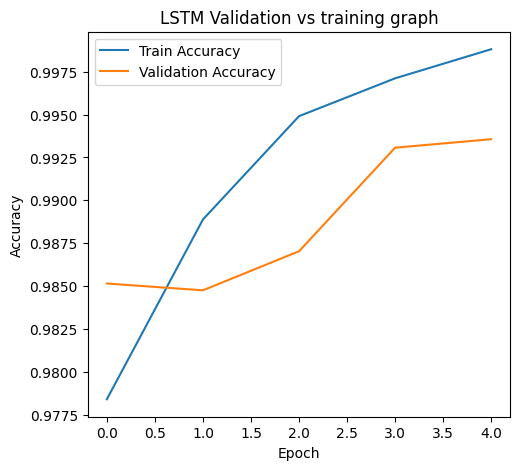

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title( 'LSTM Validation vs training graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

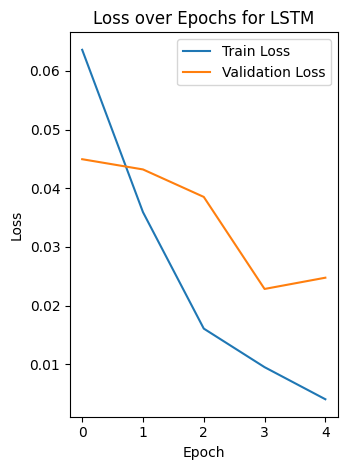

In [ ]:
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

#Predict probabilities on test data
y_probs = model.predict(X_test)

# Convert probabilities to binary predictions
y_pred = (y_probs > 0.5).astype(int)


print(classification_report(y_test, y_pred))

# calculate precision, f1 and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5890
           1       1.00      0.99      0.99      5335

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

Precision: 0.9962
Recall: 0.9897
F1-score: 0.9929


351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


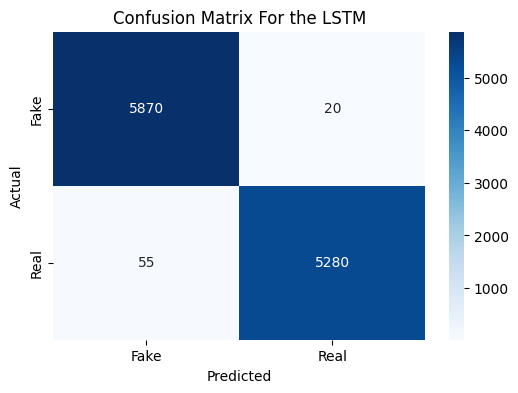

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

#Predict and convert to binary
y_probs = model.predict(X_test)
y_pred = (y_probs > 0.5).astype(int)

#confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot with seaborn heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix For the LSTM')
plt.show()


In [ ]:
# check with real news from internet (verified)
sample = ["Trump teases possible US strike as Iran supreme leader warns America"]
seq = tokenizer.texts_to_sequences(sample)
padded = pad_sequences(seq, maxlen=100)
print(model.predict(padded))
label = "Real News" if model.predict(padded)[0][0] > 0.5 else "Fake News"
print(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
[[0.01164528]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Fake News


In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Loss: {loss:.4f}")

351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - acc: 0.9936 - loss: 0.0257
Test Accuracy: 0.9933
Test Loss: 0.0246


In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)